In [1]:
import pandas as pd
import maxentep
import maxent
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# Make up some populations (take as known)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)


[ 863. 2167. 2471. 1943. 1925.  598. 1540. 3253. 1384. 3276. 1325. 2676.
  503. 4417. 1105. 1708. 2570. 1153.  540. 1683.  475. 2214.  250. 2982.
 1572. 2406. 1921. 2358.  365.  753. 2803. 4308. 3677. 1305. 3207. 1264.
 2648. 1743. 2437. 2895. 2138. 1389. 2472. 3159. 2083. 1846. 3190.  911.
 1261.  837. 1461. 2077. 2017.  700. 3313. 3549. 4474. 2487. 1296. 1682.
  916. 2360.] [156474. 127637.  55212. 103754. 141604. 124386.  46225. 100172. 130587.
 139832.  77569. 124058. 115028. 121874. 115223. 132934. 124132. 109725.
  73586. 141226.  88929.  78501. 100092. 183525. 115831. 123161.  69596.
  66960.  58838.  90993. 105394. 151360. 131418.  81882. 135977. 113579.
 102355. 146901. 103505.  42879. 129531.  56664.  87943.  78832. 110366.
  75568.  91614.  85710.  79193.  72444.  82317. 123406. 110448. 131944.
  96107. 156956.  74336.  97567. 106240. 129570. 129730.  91750.]


In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 5)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 6)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [33]:
# starting fractions probabilities
start = np.zeros((M,))  #anywhere
start[0] = 0.0001 # but likely 0

## Make starting joint

In [34]:
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.04]*2
hyper_pram.beta_var = [0.1]*2
param_model = maxentep.MetaParameterJoint(start, R, tmat, name='unbiased', n_infectious_compartments=2, hypers = hyper_pram)

## Examine some of the statistics

In [35]:
v = param_model.sample(100)

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


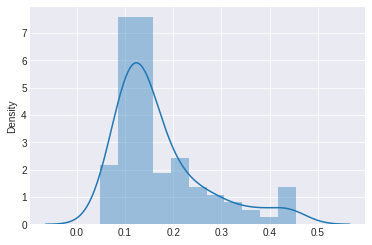

In [36]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [37]:
np.mean(v[1][:, 0, 1]), 1/5

(0.1719291, 0.2)

In [38]:
# v[2][2]

In [39]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.5771699  0.42283013 0.         0.        ]
 [0.         0.69505966 0.30494037 0.        ]
 [0.         0.         0.94124645 0.05875352]
 [0.         0.         0.         1.        ]]
[0.05771699 0.04228301 0.         0.        ] 0.10000000298023223
[7.79239068e-26 3.97118479e-17 3.17659513e-04 9.96823131e-02] 0.09999997257868883
[1.05205336e-49 6.32598671e-33 7.45241424e-07 9.99992272e-02] 0.09999997243803035
[1.42038087e-73 1.00771205e-48 1.74836501e-09 9.99999707e-02] 0.09999997243770034
[1.91766111e-97 1.60525721e-64 4.10173150e-12 9.99999724e-02] 0.09999997243769951
[2.58904089e-121 2.55712998e-080 9.62281969e-015 9.99999724e-002] 0.09999997243769948
[3.49547304e-145 4.07343679e-096 2.25755047e-017 9.99999724e-002] 0.09999997243769944
[4.71925023e-169 6.48887126e-112 5.29630015e-020 9.99999724e-002] 0.09999997243769941
[6.37147602e-193 1.03365910e-127 1.24253236e-022 9.99999724e-002] 0.09999997243769941
[8.60215178e-217 1.64659014e-143 2.91502867e-025 9.99999724e-002] 0.09999


## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [40]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
total_batches = N*batches
outs = []
timesteps = 360
infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = MetaModel(infect_fxn, timesteps, populations=population)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


(1024, 360, 62, 5)


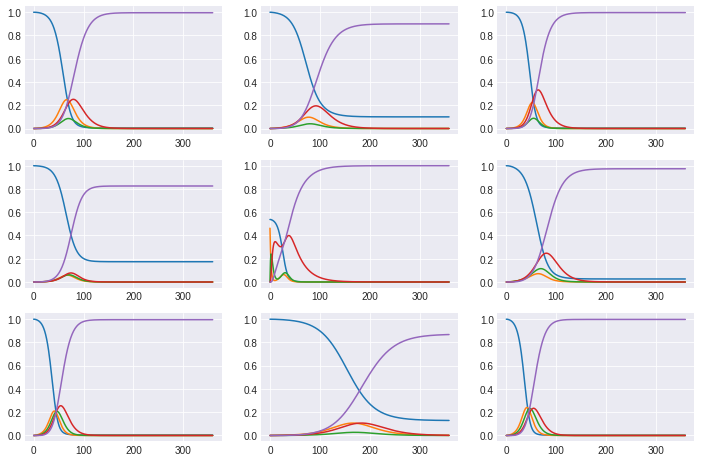

In [41]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

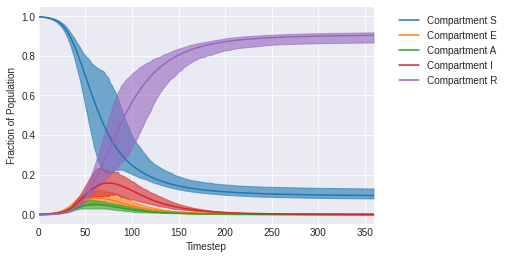

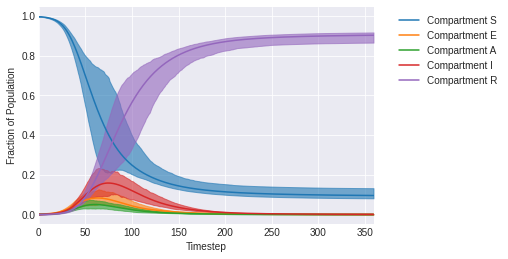

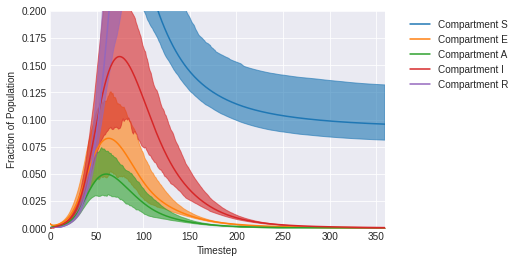

In [43]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [44]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxent.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxent.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [45]:
model = maxent.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-1), 'mean_squared_error')

In [46]:
history = model.fit(trajs, batch_size=total_batches, epochs=100, verbose=0)

In [47]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace_2 (Re multiple                  5         
_________________________________________________________________
avg_layer_laplace_2 (AvgLaye multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


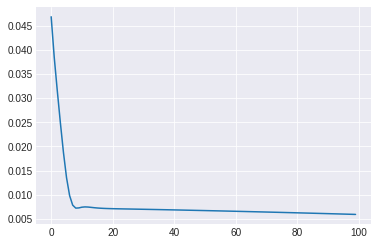

In [48]:
plt.plot(history.history['loss'])

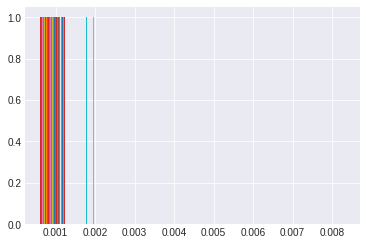

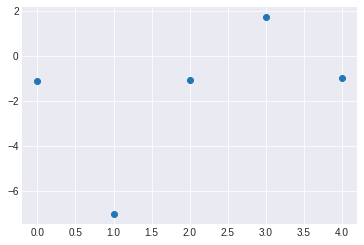

In [49]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

Plotting 62 patches in a 7 x 9 grid


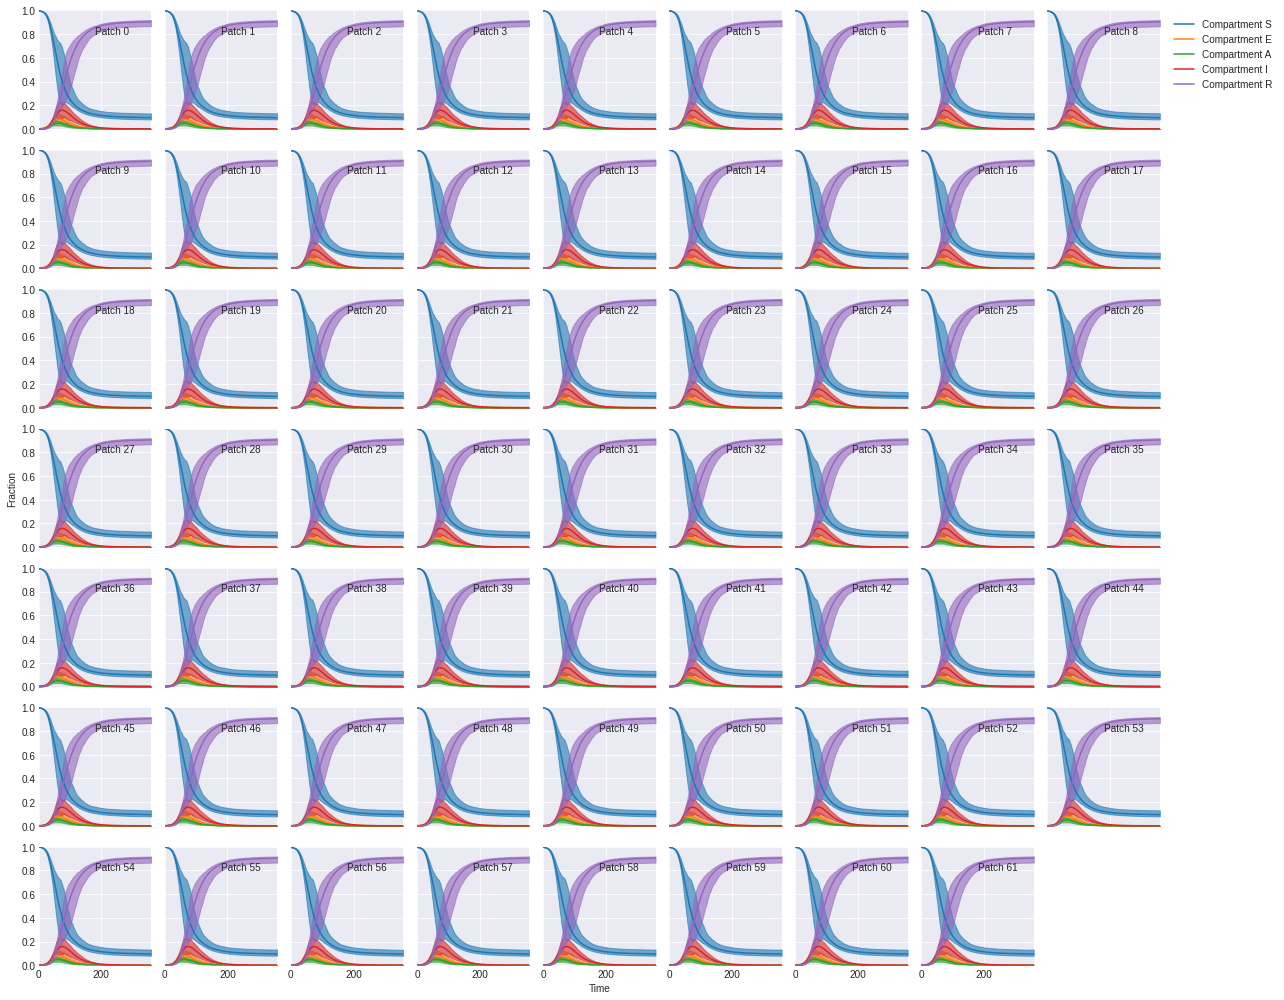

In [50]:
patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

Plotting 62 patches in a 7 x 9 grid


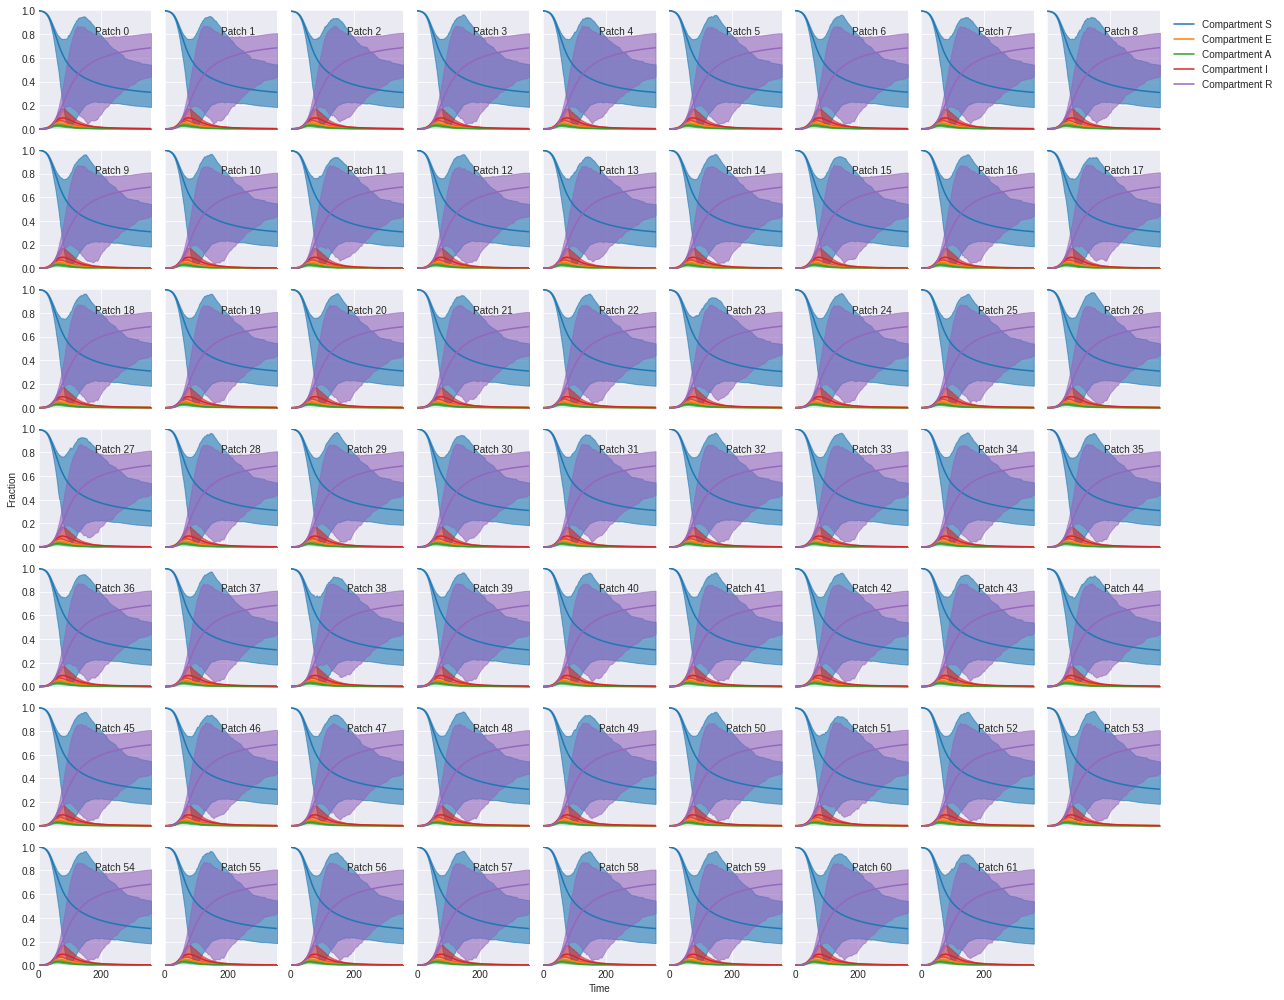

In [51]:
patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
plt.show()

## Final plots showing agreement

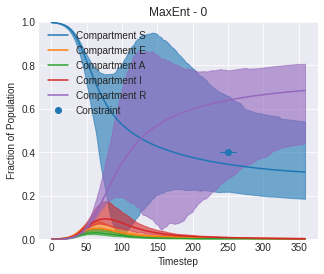

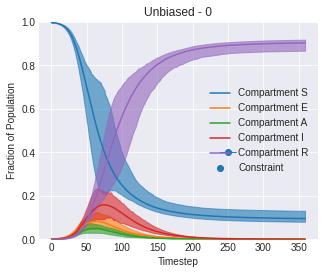

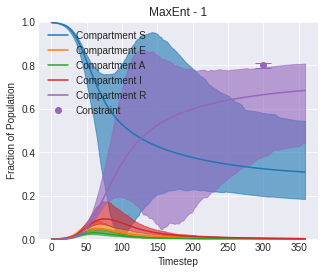

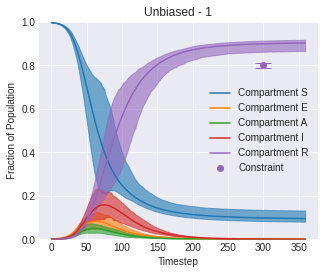

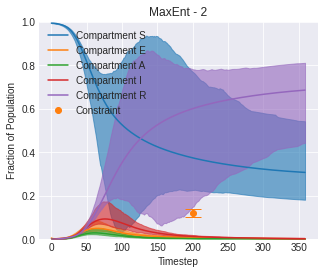

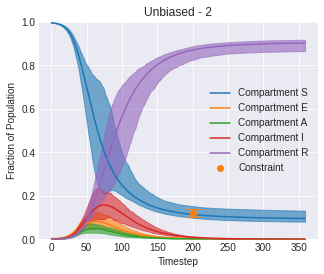

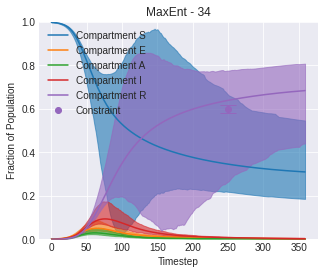

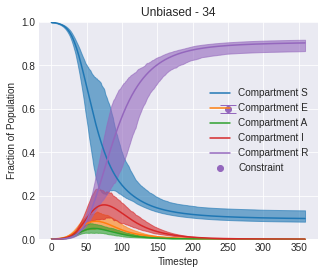

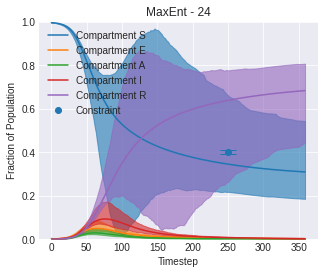

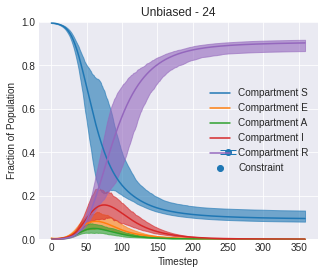

In [52]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()